In [1]:
%matplotlib inline

import os

import ipywidgets as ipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.externals import joblib

from preparation import train_valid_split
from utils import read_masks

In [2]:
meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')
meta_test = meta[meta['is_train']==0]
meta_train, meta_valid = train_valid_split( meta[meta['is_train']==1],0.2,[0,1])

In [3]:
first_k = 50
masks = joblib.load('/mnt/ml-team/dsb_2018/kuba/debug/dev_post/outputs/mask_resize')['resized_images'][:first_k]
contours = joblib.load('/mnt/ml-team/dsb_2018/kuba/debug/dev_post/outputs/contour_resize')['resized_images'][:first_k]
ground_truth = read_masks(meta_train['file_path_masks'].tolist()[:first_k])

100%|██████████| 50/50 [00:03<00:00, 26.34it/s]


In [4]:
def plot_list(images, labels):
    n_img = len(images)
    n_lab = len(labels)
    n = n_lab+n_img
    plt.figure(figsize=(16,12))
    for i, image in enumerate(images):
        plt.subplot(1,n,i+1)
        plt.imshow(image)
    for j, label in enumerate(labels):
        plt.subplot(1,n,n_img+j+1)
        plt.imshow(label, cmap='nipy_spectral')
    plt.show()

In [ ]:
for idx in range(50):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour],labels = [gt])

# Plan:
* use marker based watershed 

# Needs:
* Clean masks
* Good markers
* Good distance

# Clean Masks

## Problem 1 dirty masks

In [ ]:
idx = 5
dirty = masks[idx], contours[idx], ground_truth[idx]

plot_list(images = [dirty[0],dirty[1]],
          labels = [dirty[2]])

## Problem 2 dirty at border

In [ ]:
idx = 44
dirty_at_border = masks[idx], contours[idx], ground_truth[idx]

plot_list(images = [dirty_at_border[0],dirty_at_border[1]],
          labels = [dirty_at_border[2]])

## Approach V1

In [5]:
import skimage.morphology as morph
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi

from postprocessing import mean_blob_size

In [6]:
def clean_mask_v1(m,c):
    m_b = m > threshold_otsu(m)
    c_b = c > threshold_otsu(c)

    area, radius = mean_blob_size(m_b)
    m_ = np.where(m_b | c_b, 1, 0)
    m_ = ndi.binary_fill_holes(m_)
    m_ = np.where(c_b & (~m_b), 0, m_)
    m_ = morph.binary_opening(m_, selem=morph.disk(0.25*area))
    return m_

In [ ]:
m, c, t = dirty

m_ = clean_mask_v1(m,c)

plot_list(images = [m,c,m_],
          labels = [t]
         )

Buit it removes things that where not connected and/or things around borders

In [ ]:
m,c,t = dirty_at_border
m_ = clean_mask_v1(m,c)

plot_list(images = [m,c,m_],
          labels = [t]
         )

## Approach V2

In [7]:
from postprocessing import pad_mask, crop_mask, drop_artifacts

In [8]:
def clean_mask_v2(m,c):
    # threshold
    m_thresh = threshold_otsu(m)
    c_thresh = threshold_otsu(c)
    m_b = m > m_thresh
    c_b = c > c_thresh

    # combine contours and masks and fill the cells
    m_ = np.where(m_b | c_b, 1, 0)
    m_ = ndi.binary_fill_holes(m_)

    # close what wasn't closed before 
    area, radius = mean_blob_size(m_b)
    struct_size = int(6*radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(m_, pad=struct_size)
    m_padded = morph.binary_closing(m_padded, selem=struct_el)
    m_ = crop_mask(m_padded, crop=struct_size)
    
    # open to cut the real cells from the artifacts
    area, radius = mean_blob_size(m_b)
    struct_size = int(4*radius)
    struct_el = morph.disk(struct_size)
    m_ = np.where(c_b & (~m_b), 0, m_)
    m_padded = pad_mask(m_, pad=struct_size)
    m_padded = morph.binary_opening(m_padded, selem=struct_el)
    m_ = crop_mask(m_padded, crop=struct_size)

    # join the connected cells with what we had at the beginning
    m_ = np.where(m_b|m_,1,0)
    m_ = ndi.binary_fill_holes(m_)
    
    # drop all the cells that weren't present at least in 25% of area in the initial mask 
    m_ = drop_artifacts(m_, m_b,min_coverage=0.25)
    
    return m_

In [ ]:
m,c,t = dirty_at_border
m_ = clean_mask_v2(m,c)

plot_list(images = [m,c,m_],
          labels = [t]
         )

In [ ]:
for idx in range(5):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask],labels = [gt])

# Problem 3 not everything gets filled

In [ ]:
for idx in [38]:
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask],labels = [gt])

# Problem 4 some cells get connected

In [ ]:
for idx in [0]:
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask],labels = [gt])

# Ideas:
* work more with dilation
* do better around borders
* drop some cells after watershed with drop_artifact function

In [9]:
def clean_mask_v3(m,c):
    return

# Good Markers

# Approach v1

In [10]:
def good_markers_v1(m,c):
    # threshold
    m_thresh = threshold_otsu(m)
    c_thresh = threshold_otsu(c)
    m_b = m > m_thresh
    c_b = c > c_thresh
    
    mk_ = np.where(c_b,0,m)
    return mk_

0


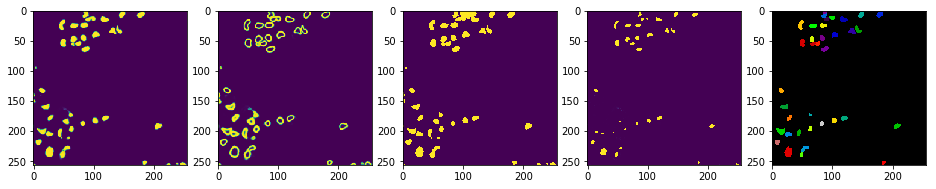

1


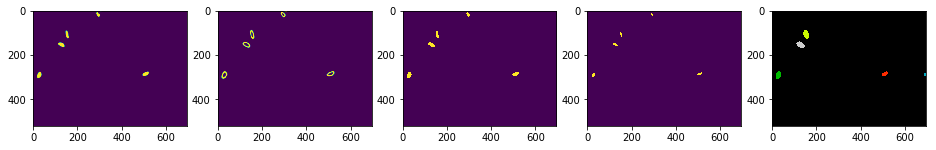

2


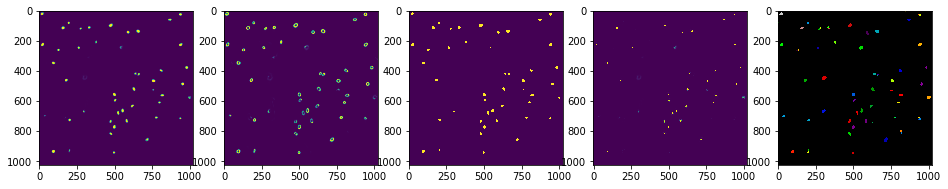

3


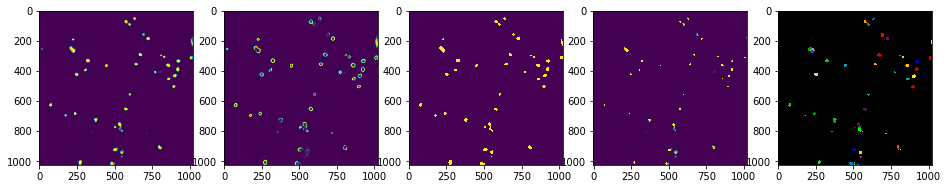

4


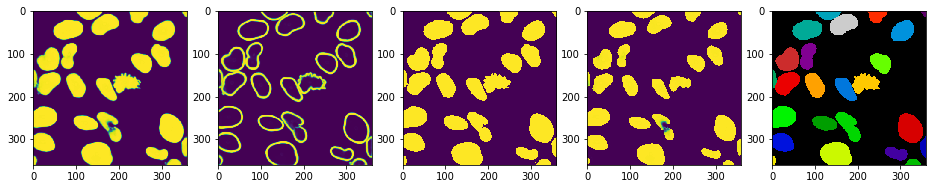

5


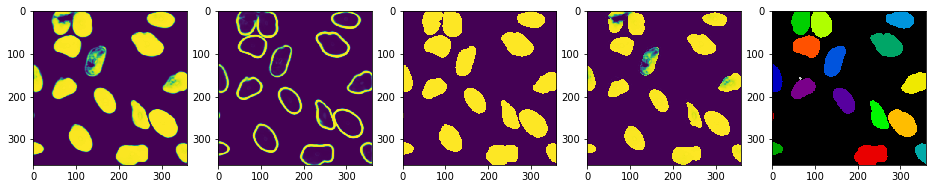

6


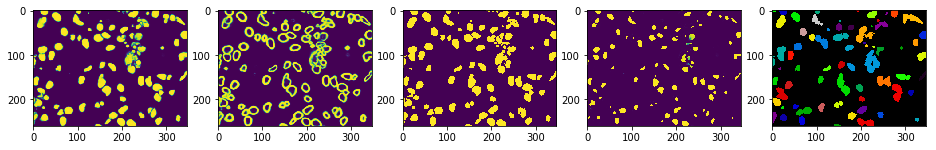

7


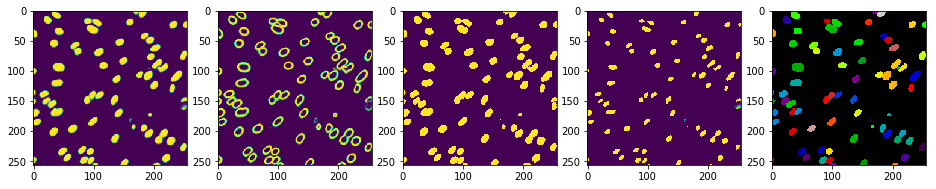

8


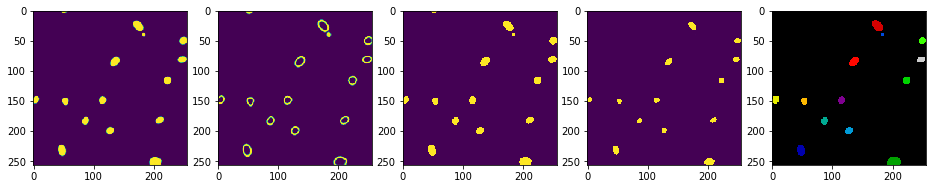

9


KeyboardInterrupt: 

In [10]:
for idx in range(10):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v1(mask,contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask, good_markers],labels = [gt])

## Problem 1 building markers on initial mask when we have better mask

In [11]:
def good_markers_v2(m_b,c):
    # threshold
    c_thresh = threshold_otsu(c)
    c_b = c > c_thresh
    
    mk_ = np.where(c_b,0,m_b)
    return mk_

In [ ]:
for idx in range(10):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v2(cleaned_mask,contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask, good_markers],labels = [gt])

## Problem 2 some markers are to large and connected

In [12]:
def good_markers_v3(m_b,c):
    # threshold
    c_thresh = threshold_otsu(c)
    c_b = c > c_thresh
    
    mk_ = np.where(c_b,0,m_b)
    
    area, radius = mean_blob_size(m_b)
    struct_size = int(radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(mk_, pad=struct_size)
    m_padded = morph.erosion(m_padded, selem=struct_el)
    mk_ = crop_mask(m_padded, crop=struct_size)
    mk_,_ = ndi.label(mk_) 
    return mk_

In [ ]:
for idx in range(50):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask],labels = [good_markers, gt])

## Problem 3 still some barely connected markers are left

In [ ]:
for idx in [25,27]:
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    gt = ground_truth[idx]
    
    plot_list(images = [mask,contour, cleaned_mask],labels = [good_markers, gt])

## Problem 4 we are dropping markers on many images with small cells

## Ideas
* play with binary closing/opening
* involve contours and/or centers in this
* we will asume that lost markers are in facet small cells that don't need to be divided and we will get back all the cells that were dropped in watershed
* use local maxima on distance transform

In [13]:
def good_markers_v4(m_b,c):
    return

# Good distance

In [14]:
def good_distance_v1(m_b):
    distance = ndi.distance_transform_edt(m_b)
    return distance

In [ ]:
for idx in range(50):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    gt = ground_truth[idx]
    
    plot_list(images = [cleaned_mask, good_distance],labels = [good_markers, gt])

## Idea
* investigate imposing some gradients on original image or good clean mask

## Watershed

In [15]:
def watershed_v1(mask, contour):
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    water = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)
    
    return water

0


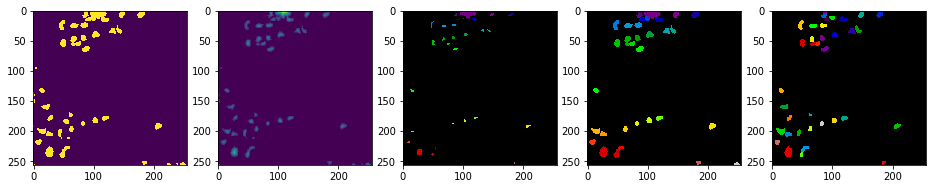

1


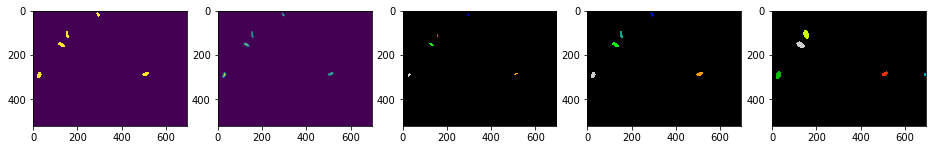

2


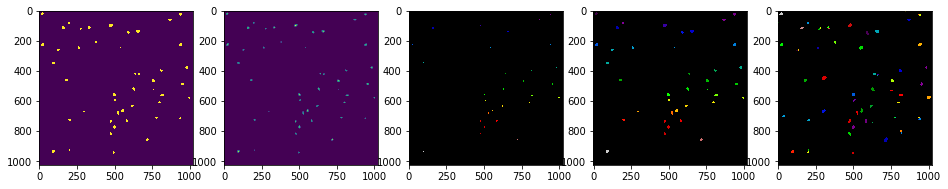

3


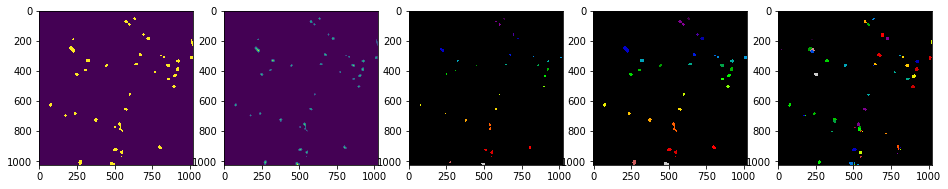

4


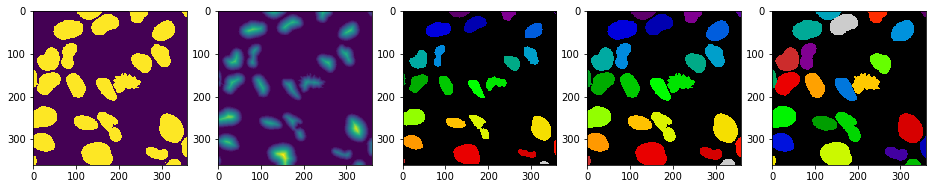

In [18]:
for idx in range(5):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    water = watershed_v1(mask, contour)
    
    gt = ground_truth[idx]
    
    plot_list(images = [cleaned_mask, good_distance],labels = [good_markers, water,gt])

## Problem 1 some cells are dumped

## Problem 2 some artifacts from mask_cleaning remain

In [16]:
from postprocessing import drop_artifacts_per_label, add_dropped_water_blobs

In [17]:
def watershed_v2(mask, contour):
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    water = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)
    
    water = add_dropped_water_blobs(water, cleaned_mask)
    
    m_thresh = threshold_otsu(mask)
    initial_mask_binary = (mask > m_thresh).astype(np.uint8)
    water = drop_artifacts_per_label(water,initial_mask_binary)
    return water

0


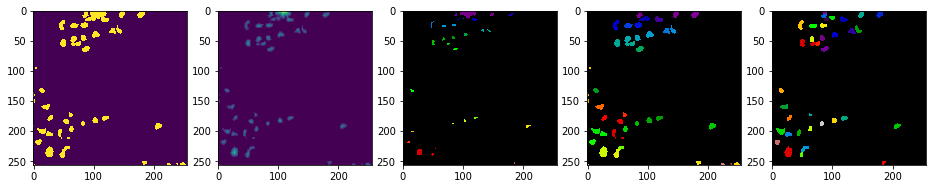

1


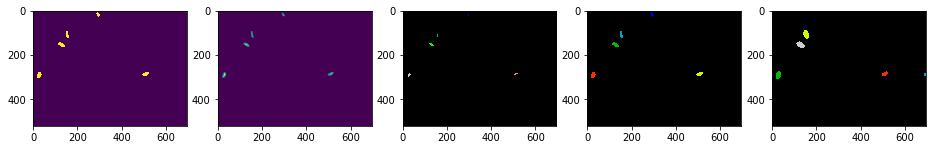

2


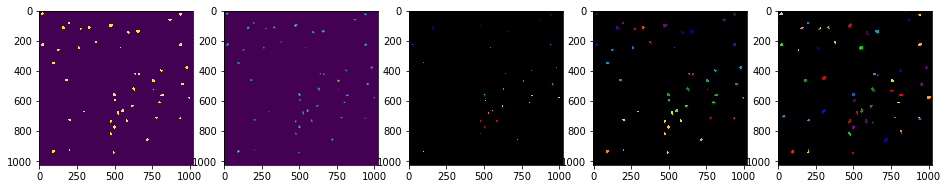

3


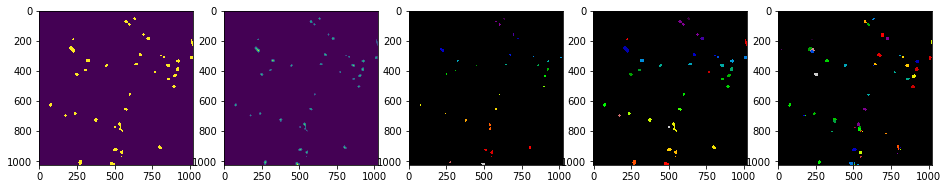

4


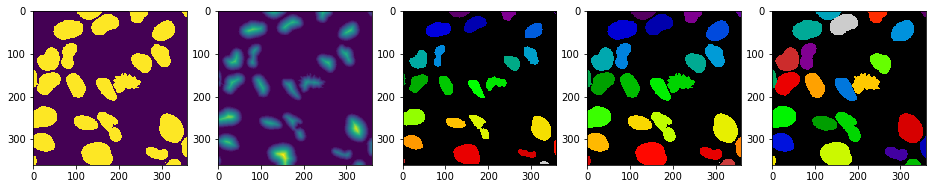

5


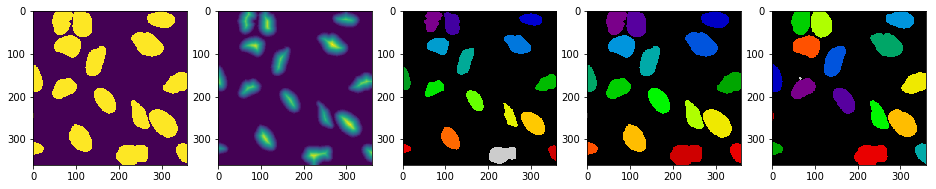

6


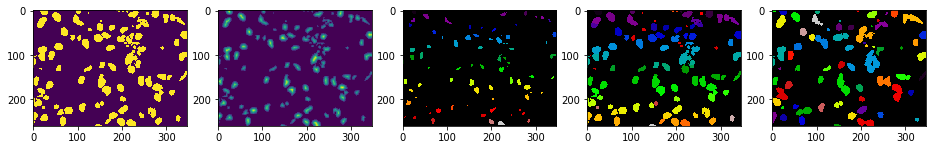

7


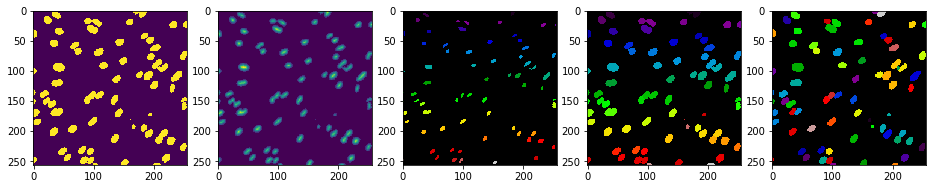

8


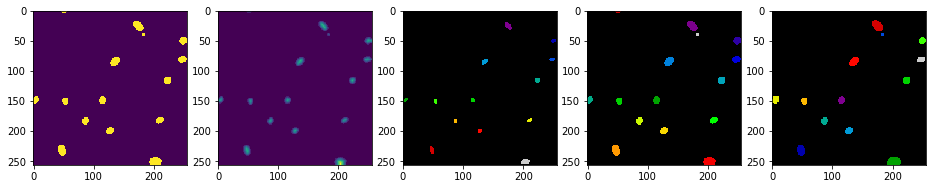

9


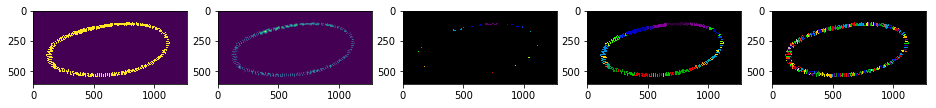

10


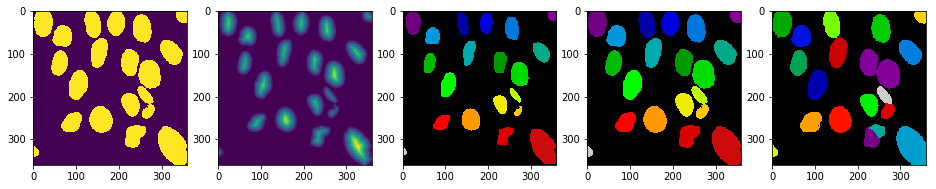

11


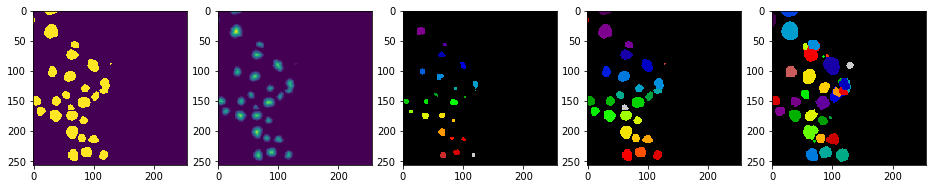

12


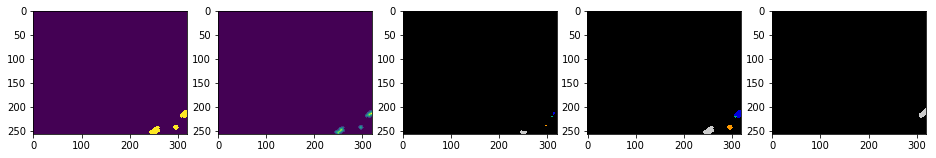

13


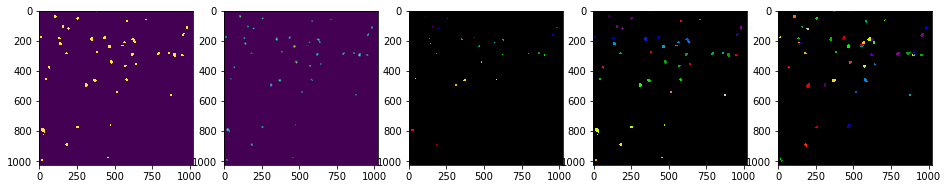

14


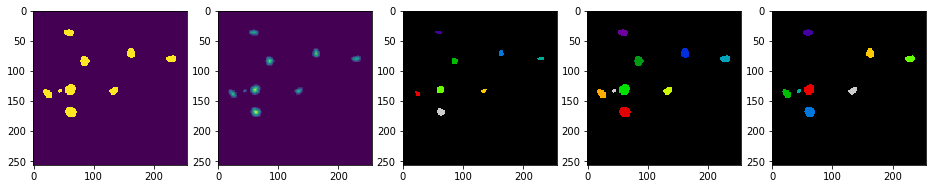

15


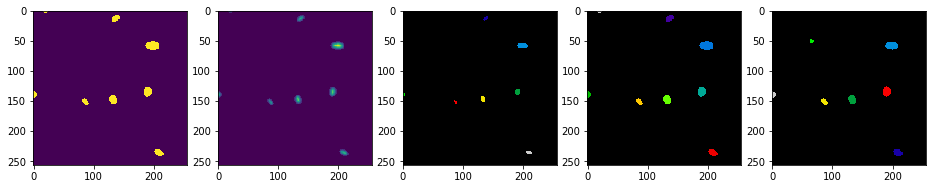

16


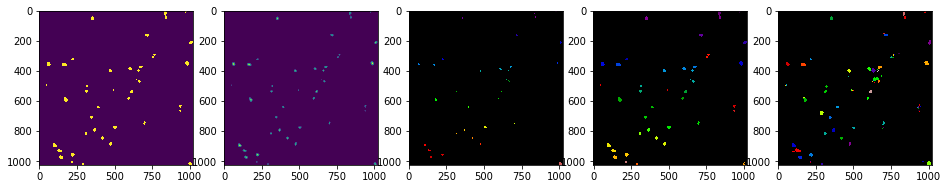

17


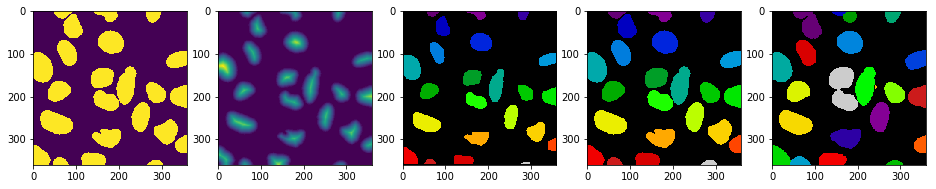

18


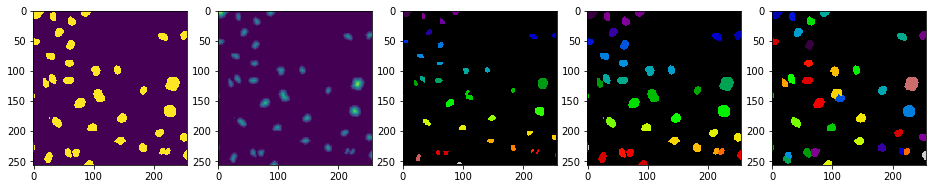

19


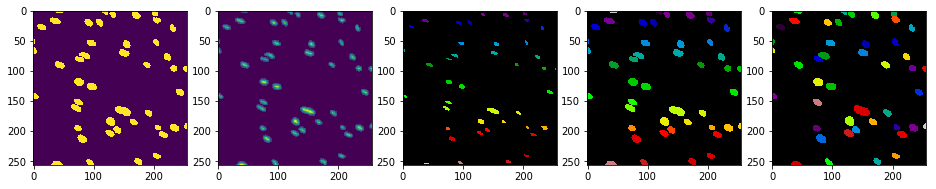

20


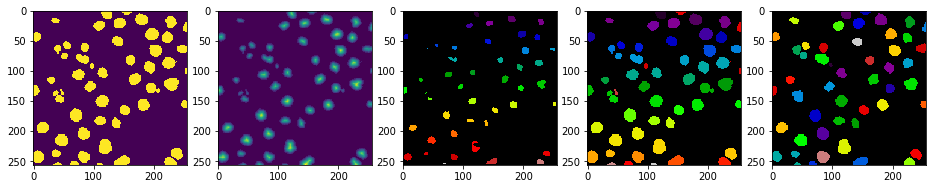

21


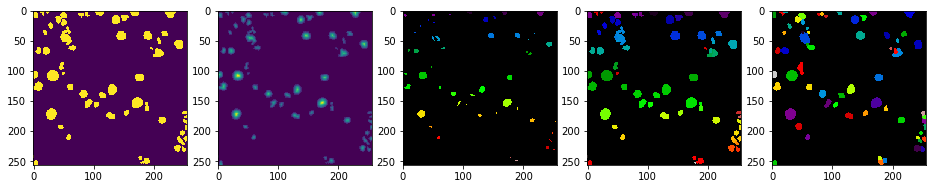

22


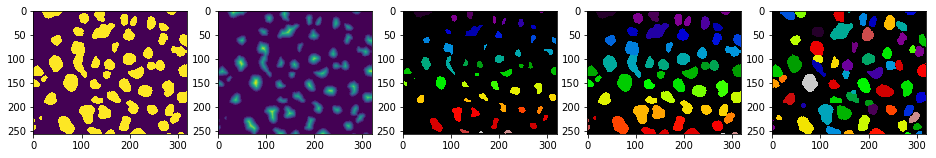

23


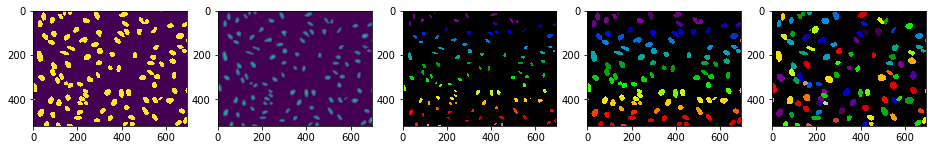

24


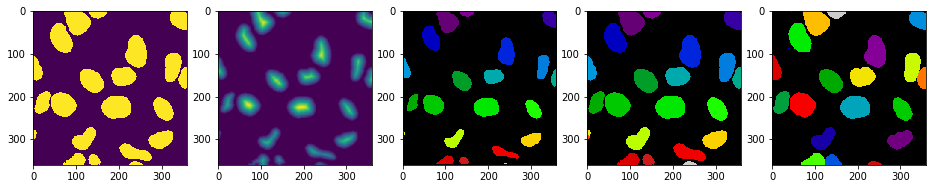

25


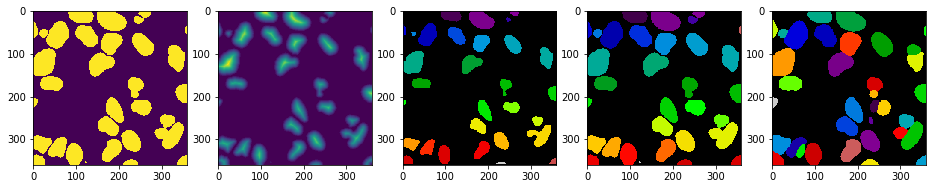

26


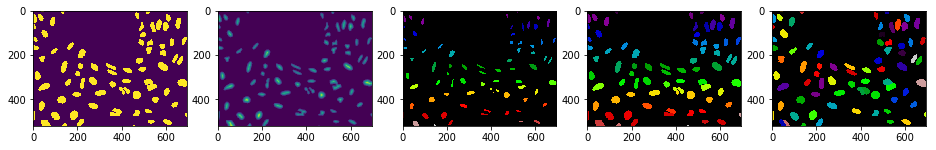

27


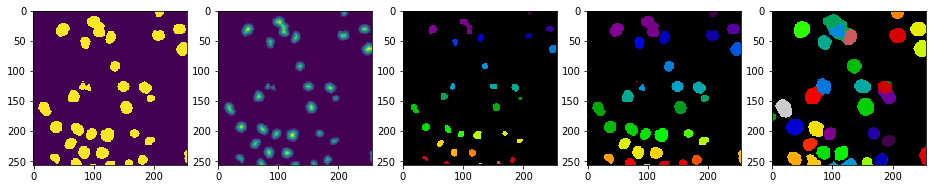

28


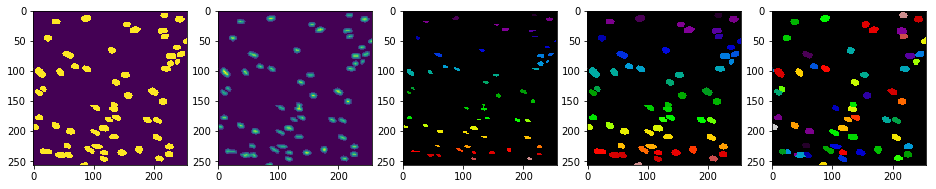

29


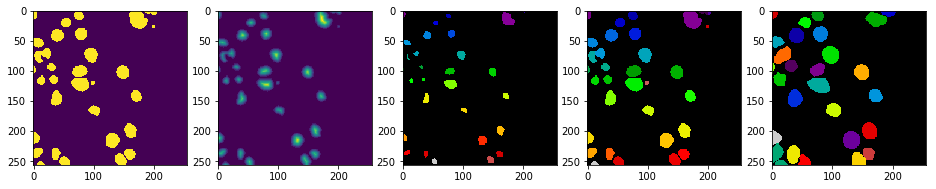

30


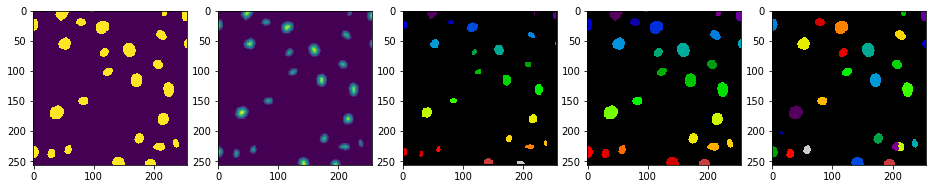

31


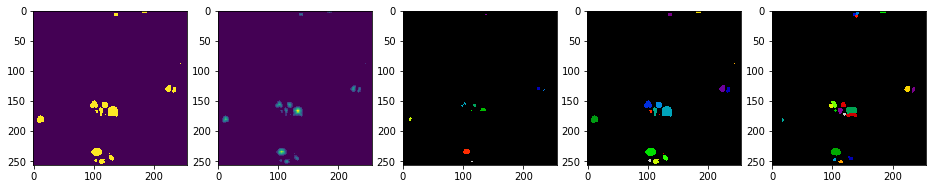

32


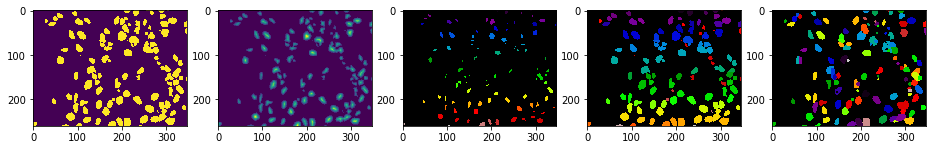

33


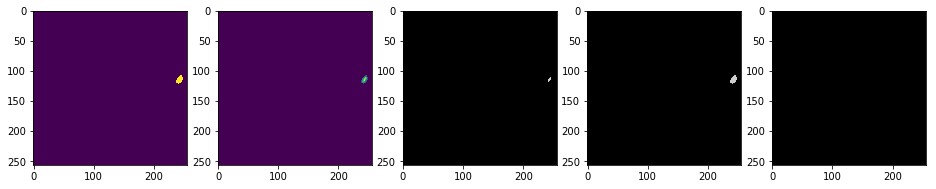

34


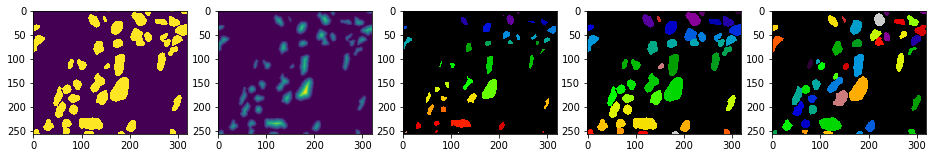

35


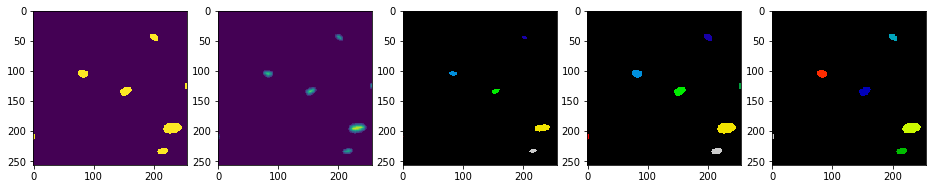

36


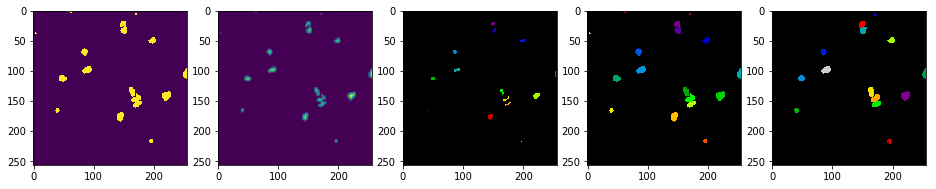

37


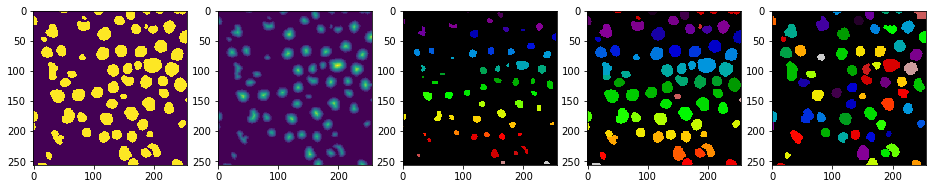

38


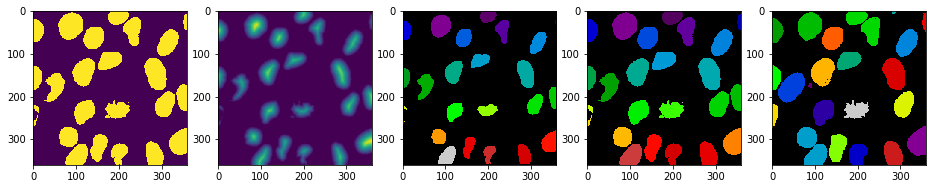

39


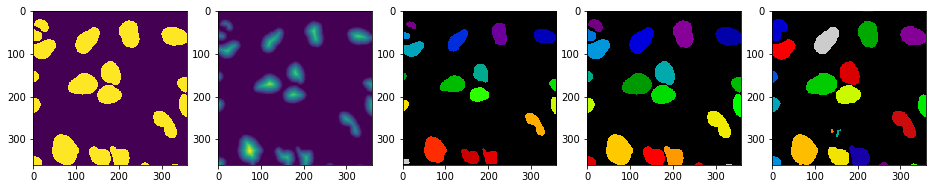

40


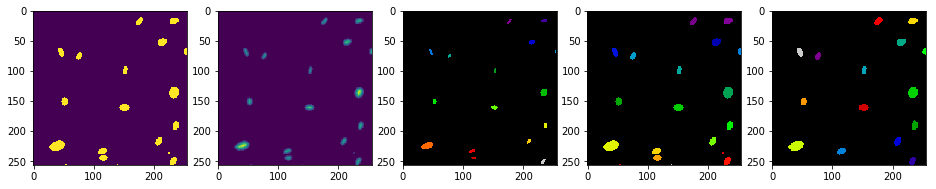

41


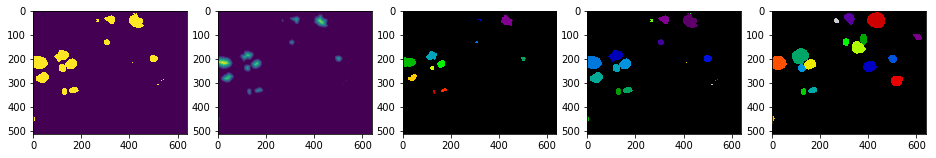

42


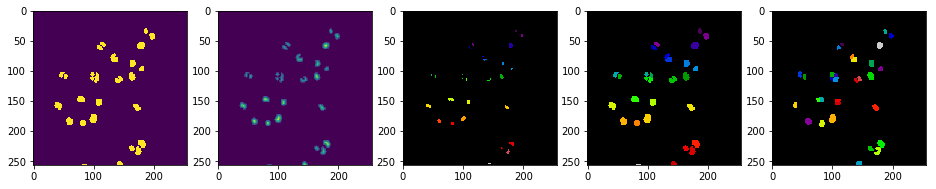

43


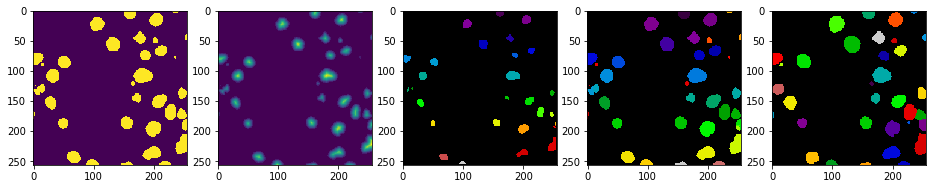

44


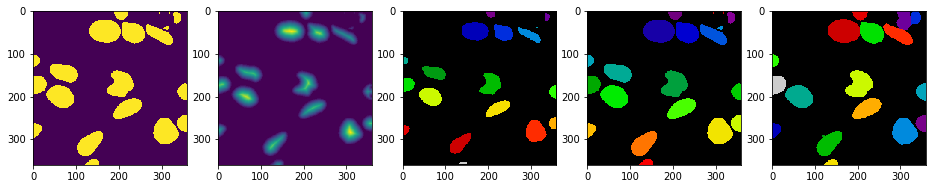

45


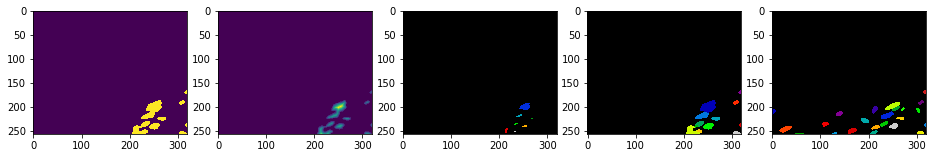

46


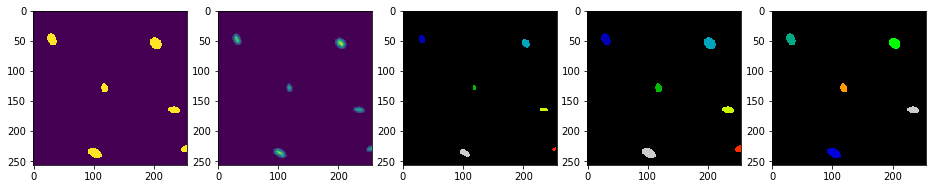

47


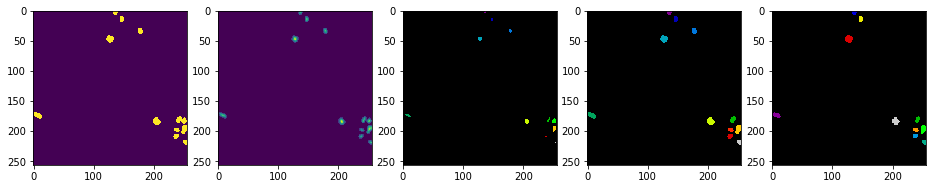

48


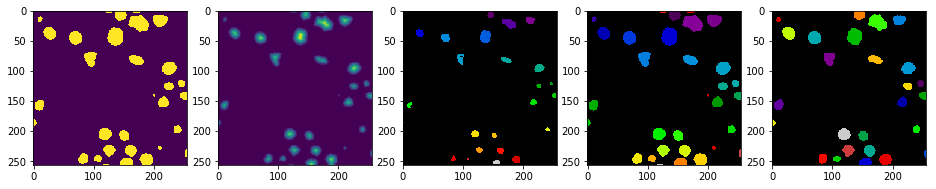

49


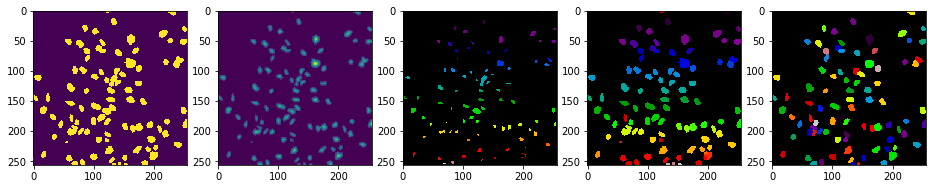

In [19]:
for idx in range(50):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    water = watershed_v2(mask, contour)
    
    gt = ground_truth[idx]
    
    plot_list(images = [cleaned_mask, good_distance],labels = [good_markers, water,gt])

## Problem 3 some cells are oversemgmented and small cell chunks remain
When the oversegmented component is dropped the hole might need to be filled

In [24]:
from postprocessing import drop_small, fill_holes_per_blob

In [27]:
def watershed_v3(mask, contour):
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    labels = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)
    
    labels = add_dropped_water_blobs(labels, cleaned_mask)
    
    m_thresh = threshold_otsu(mask)
    initial_mask_binary = (mask > m_thresh).astype(np.uint8)
    labels = drop_artifacts_per_label(labels,initial_mask_binary)
    
    labels = drop_small(labels, min_size=20)
    labels = fill_holes_per_blob(labels)
        
    return labels

0


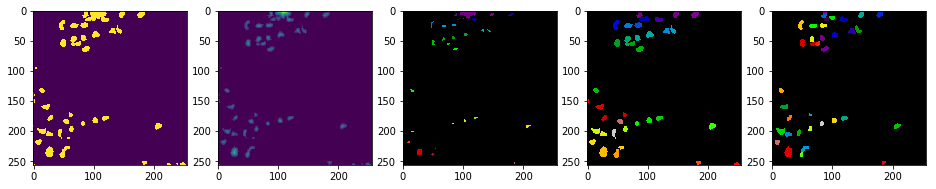

1


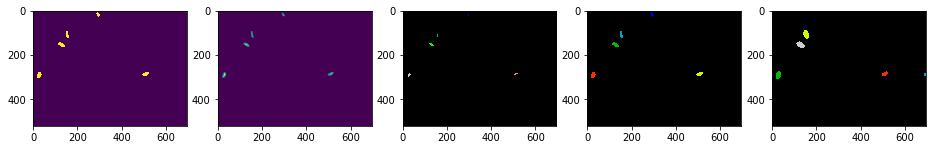

2


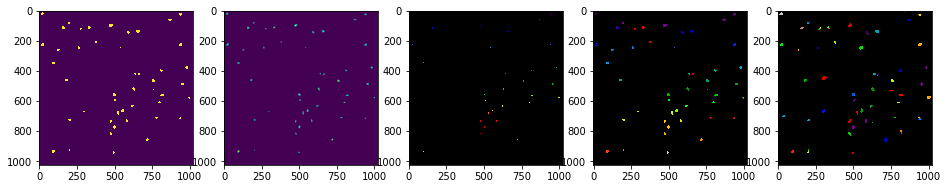

3


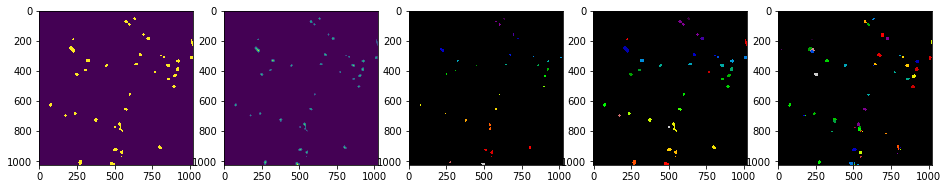

4


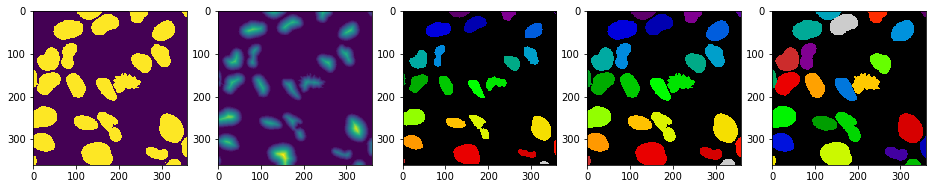

5


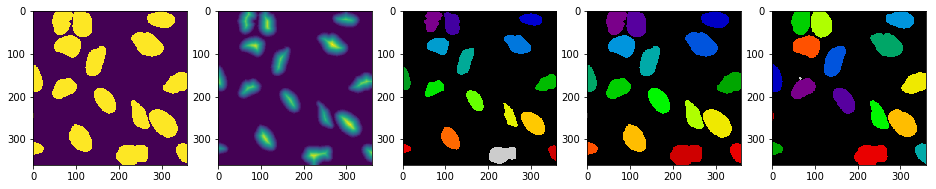

6


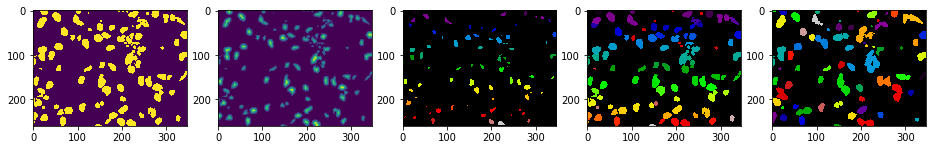

7


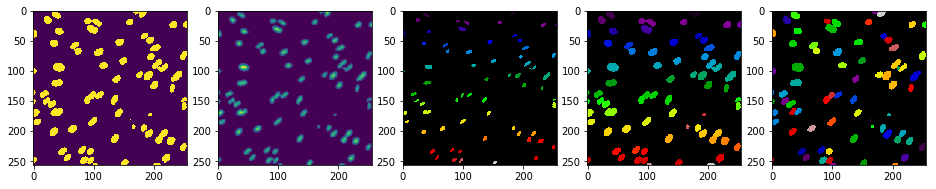

8


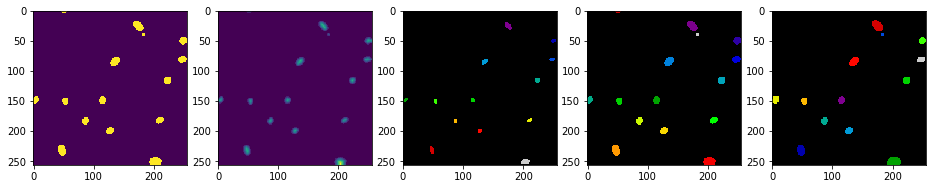

9


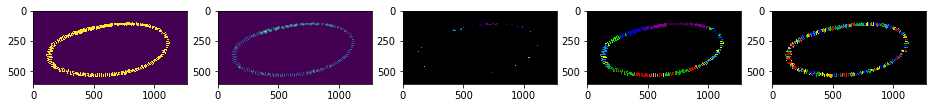

10


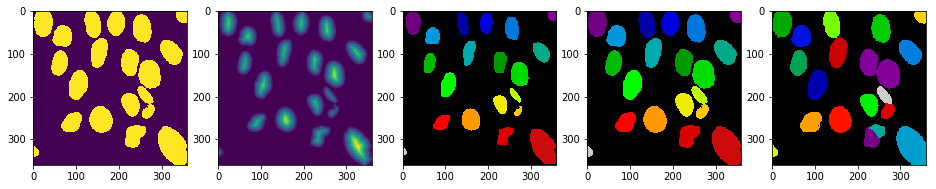

11


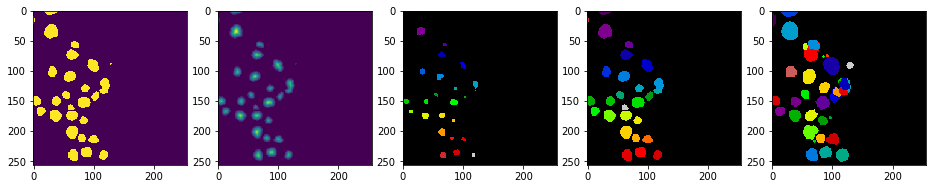

12


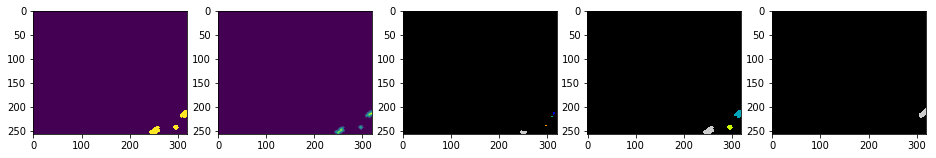

13


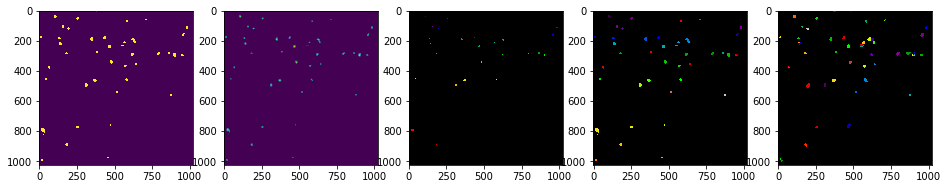

14


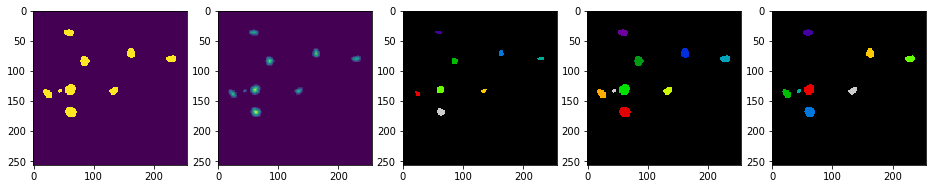

15


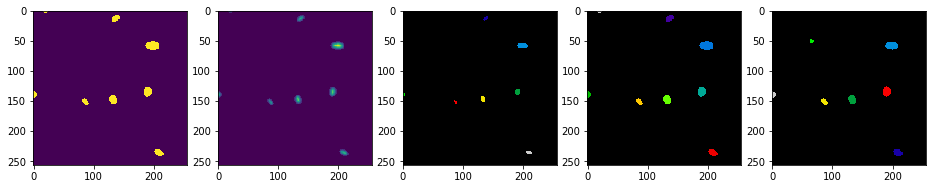

16


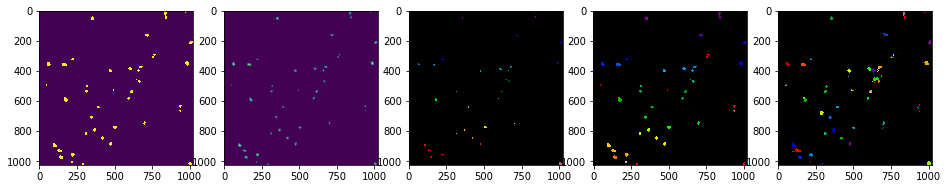

17


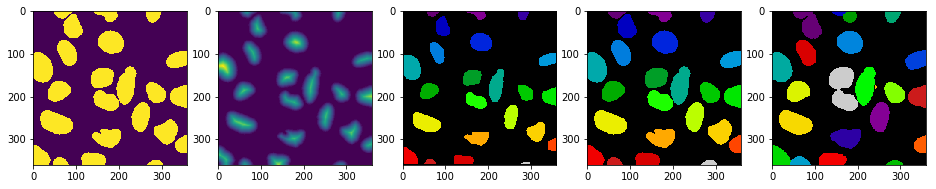

18


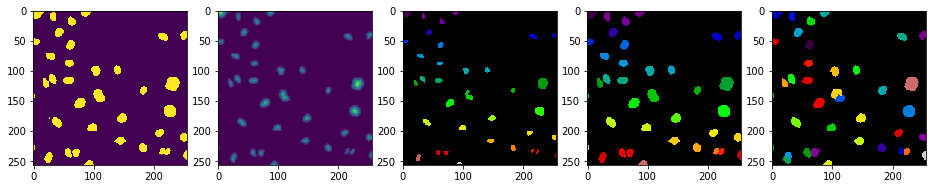

19


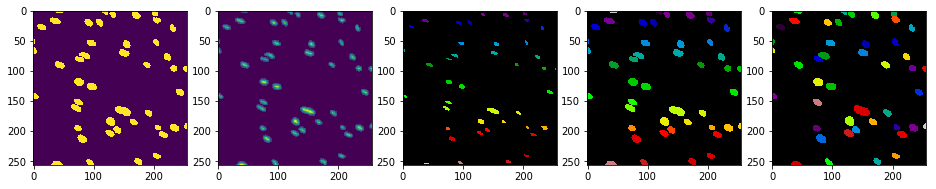

20


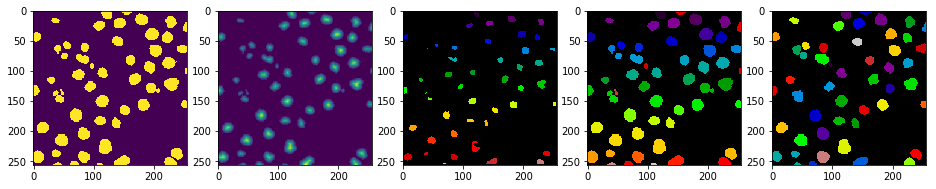

21


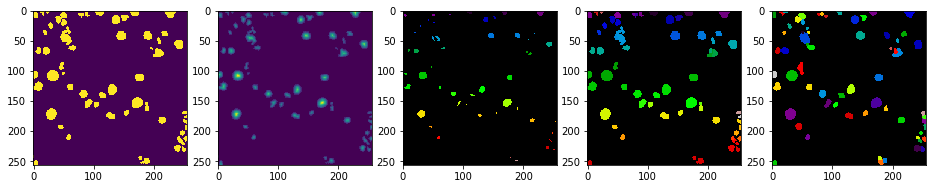

22


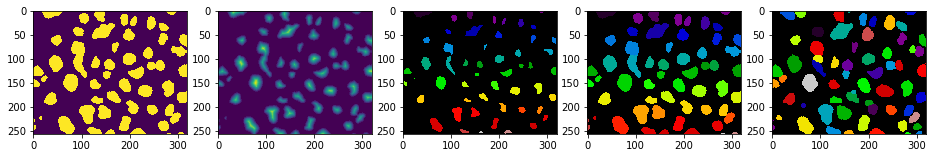

23


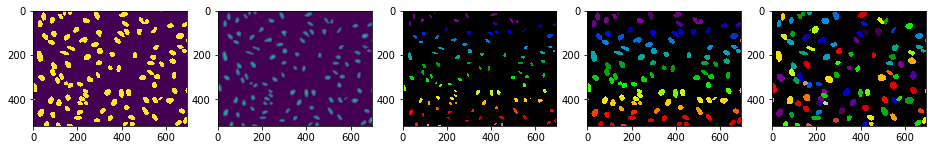

24


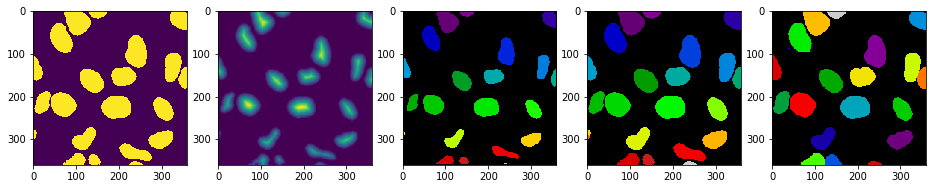

25


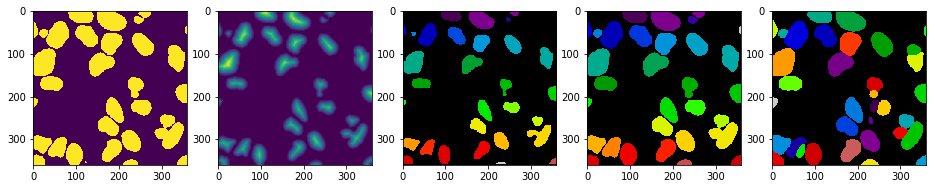

26


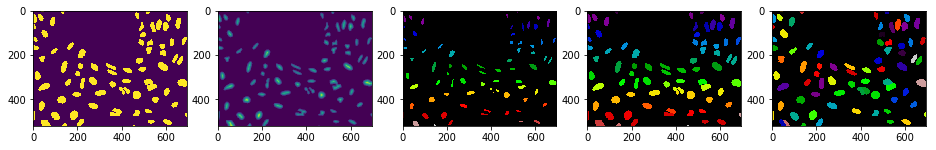

27


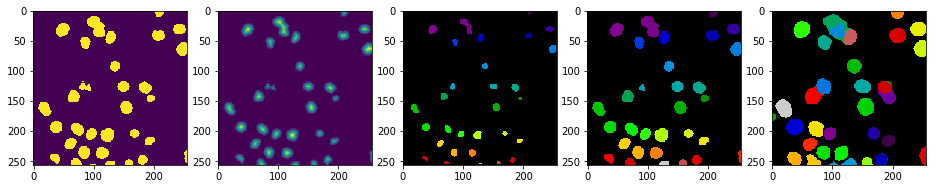

28


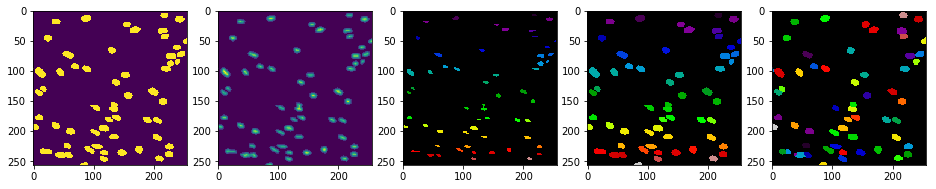

29


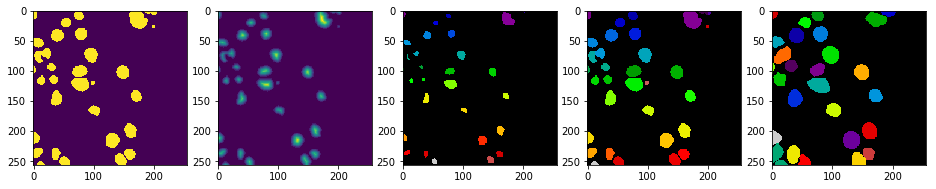

30


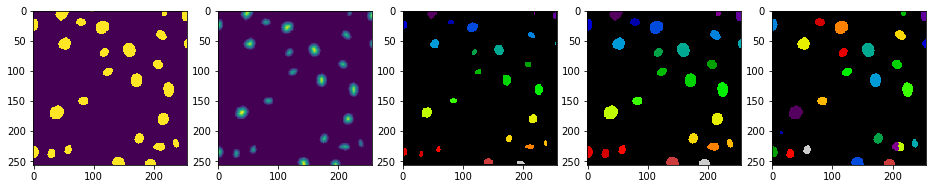

31


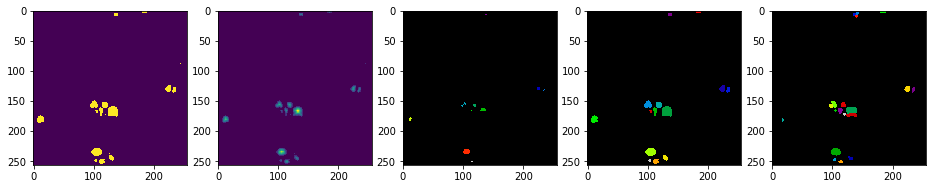

32


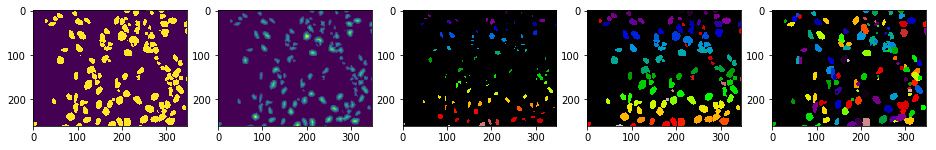

33


/mnt/ml-team/homes/jakub.czakon/.env/dl_py3/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


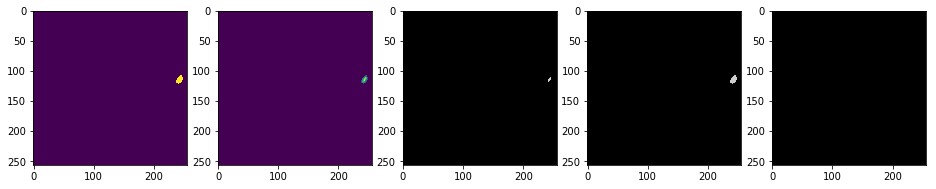

34


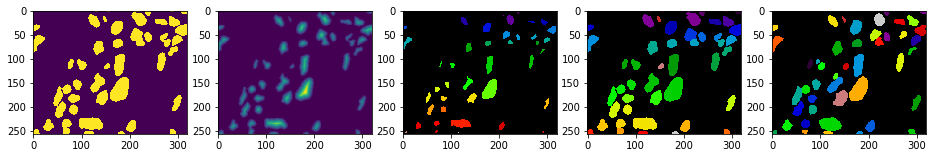

35


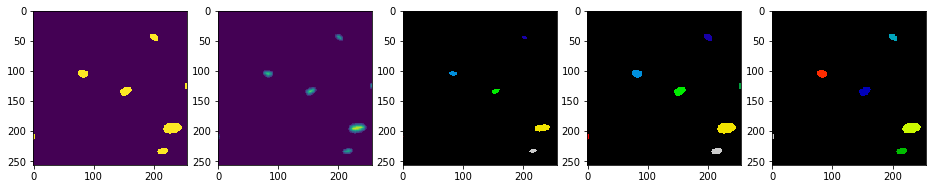

36


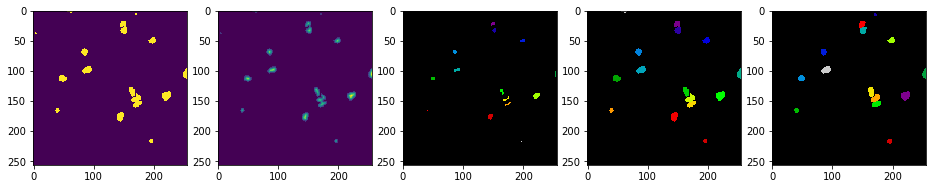

37


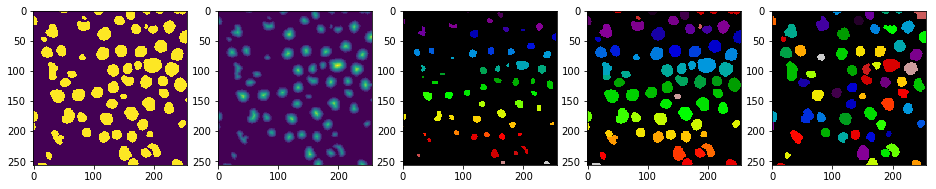

38


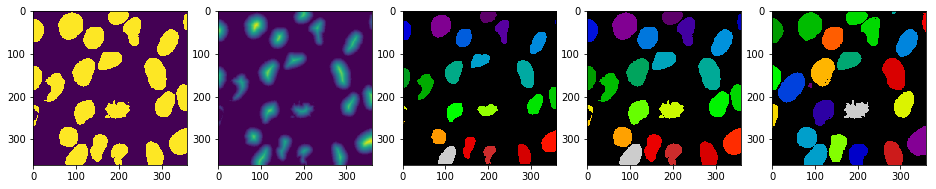

39


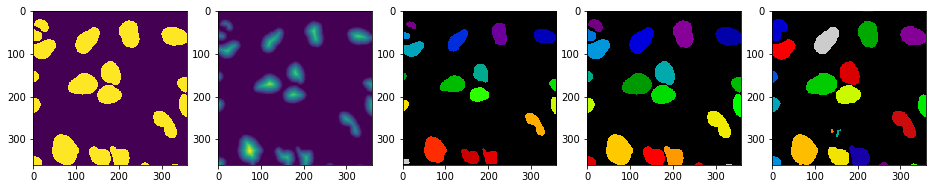

40


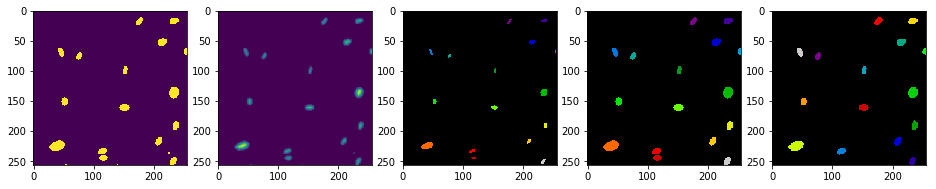

41


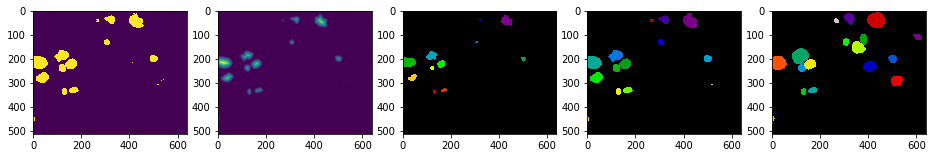

42


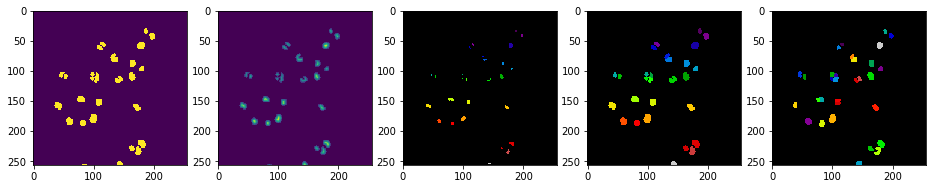

43


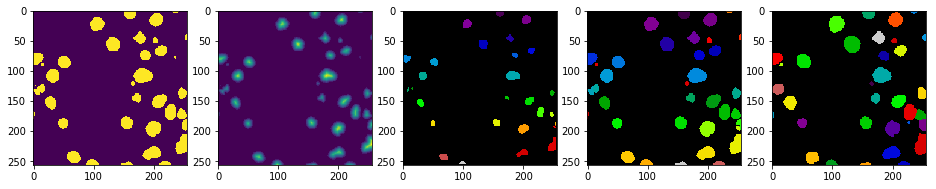

44


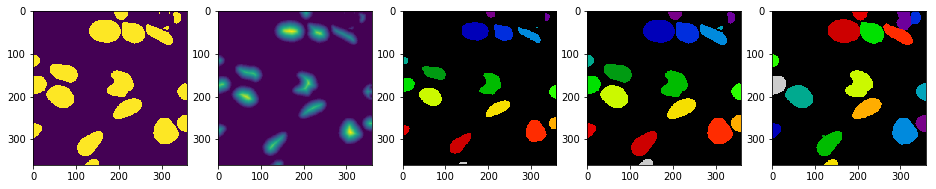

45


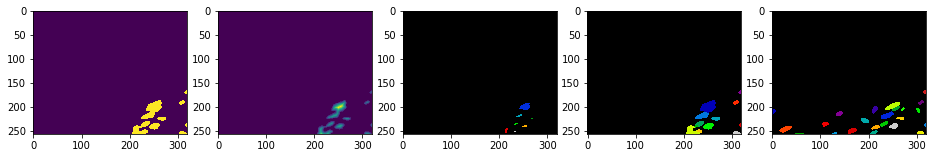

46


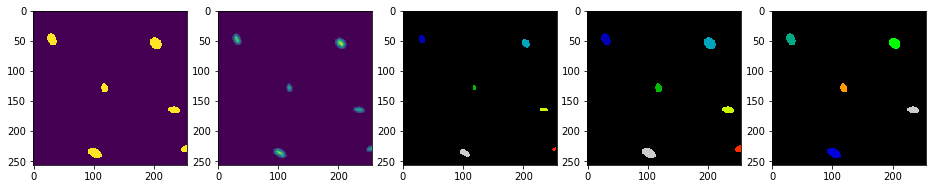

47


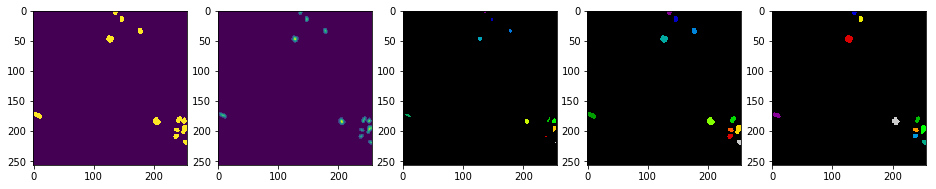

48


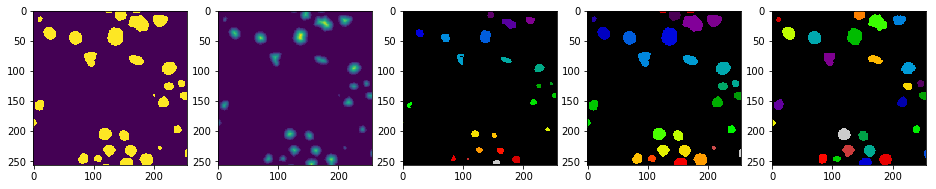

49


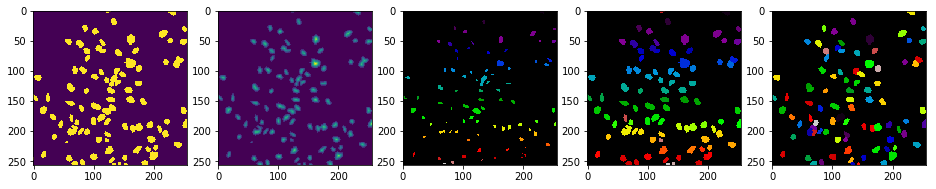

In [28]:
for idx in range(50):
    print(idx)
    mask = masks[idx]
    contour = contours[idx]
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    water = watershed_v3(mask, contour)
    
    gt = ground_truth[idx]
    
    plot_list(images = [cleaned_mask, good_distance],labels = [good_markers, water,gt])

## Problem 4 small oversegmented elements should be added to bigger components and not dropped

In [23]:
def connect_or_drop_small(labels, min_size):
    return NotImplementedError

def watershed_v4(mask, contour):
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    labels = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)
    
    labels = add_dropped_water_blobs(labels, cleaned_mask)
    
    m_thresh = threshold_otsu(mask)
    initial_mask_binary = (mask > m_thresh).astype(np.uint8)
    labels = drop_artifacts_per_label(labels,initial_mask_binary)
    
    labels = connect_or_drop_small(labels, min_size=20)
    labels = fill_holes_per_blob(labels)
        
    return water